In [1]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
# baca data
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [6]:
# cek jumlah baris dan kolom data 
print(f"jumlah baris df adalah {df.shape[0]}")
print(f"jumlah kolom df adalah {df.shape[1]}")

jumlah baris df adalah 100000
jumlah kolom df adalah 9


In [8]:
# lihat info data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [11]:
# cek null values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [14]:
# lihat ada berapa baris data yang duplikat 
df.duplicated().sum()

3854

In [16]:
# hapus data duplikat 
df.drop_duplicates(inplace = True)

# cek lagi apakah sudah tidak ada data duplikat 
df.duplicated().sum()

0

In [19]:
# lihat apa saja isi dari kolom gender 
df["gender"].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [21]:
# ubah kolom gender menjadi numerik dengan one hot enccoding 
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

In [23]:
# lihat apa saja isi dari kolom smoking_history
df["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [25]:
# ubah kolom smoking_history menjadi numerik dengan one hot enccoding 
df = pd.get_dummies(df, columns=['smoking_history'], prefix='smoking_history')

In [27]:
# cek info df lagi 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          96146 non-null  float64
 1   hypertension                 96146 non-null  int64  
 2   heart_disease                96146 non-null  int64  
 3   bmi                          96146 non-null  float64
 4   HbA1c_level                  96146 non-null  float64
 5   blood_glucose_level          96146 non-null  int64  
 6   diabetes                     96146 non-null  int64  
 7   gender_Female                96146 non-null  bool   
 8   gender_Male                  96146 non-null  bool   
 9   gender_Other                 96146 non-null  bool   
 10  smoking_history_No Info      96146 non-null  bool   
 11  smoking_history_current      96146 non-null  bool   
 12  smoking_history_ever         96146 non-null  bool   
 13  smoking_history_forme

In [29]:
# ubah kolom boolean menajadi int
# Mengonversi hanya kolom one-hot encoding menjadi integer
df[['gender_Female', 'gender_Male', 'gender_Other']] = df[['gender_Female', 'gender_Male', 'gender_Other']].astype(int)
df[['smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']] = df[['smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']].astype(int)

In [32]:
# pisahkan fitur dan target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [35]:
# split data 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [37]:
print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)

Train Shape: (76916, 15)
Validation Shape: (9615, 15)
Test Shape: (9615, 15)


In [40]:
# deteksi outlier di training data
columns_to_check = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

In [42]:
# fungsi untuk deteksi outlier menggunakan iqr
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [44]:
outliers_summary = {}
for column in columns_to_check:
    outliers = detect_outliers_iqr(X_train, column)
    outliers_summary[column] = {
        'outliers_count': len(outliers),
        'outliers_indices': outliers.index.tolist()
    }

In [46]:
# Lihat jumlah keseluruhan outlier
for column, summary in outliers_summary.items():
    print(f"Column: {column}")
    print(f"Outliers count: {summary['outliers_count']}")
    print(f"Outliers indices: {summary['outliers_indices'][:10]} (first 10 shown)")
    print("-")

Column: age
Outliers count: 0
Outliers indices: [] (first 10 shown)
-
Column: bmi
Outliers count: 4244
Outliers indices: [27089, 24627, 99579, 81589, 88027, 26560, 90498, 14159, 52082, 31924] (first 10 shown)
-
Column: HbA1c_level
Outliers count: 1041
Outliers indices: [75278, 72102, 53234, 2371, 92746, 73801, 65271, 69684, 87424, 92835] (first 10 shown)
-
Column: blood_glucose_level
Outliers count: 1598
Outliers indices: [19199, 88027, 2930, 93029, 8934, 28471, 74670, 79710, 94021, 4986] (first 10 shown)
-


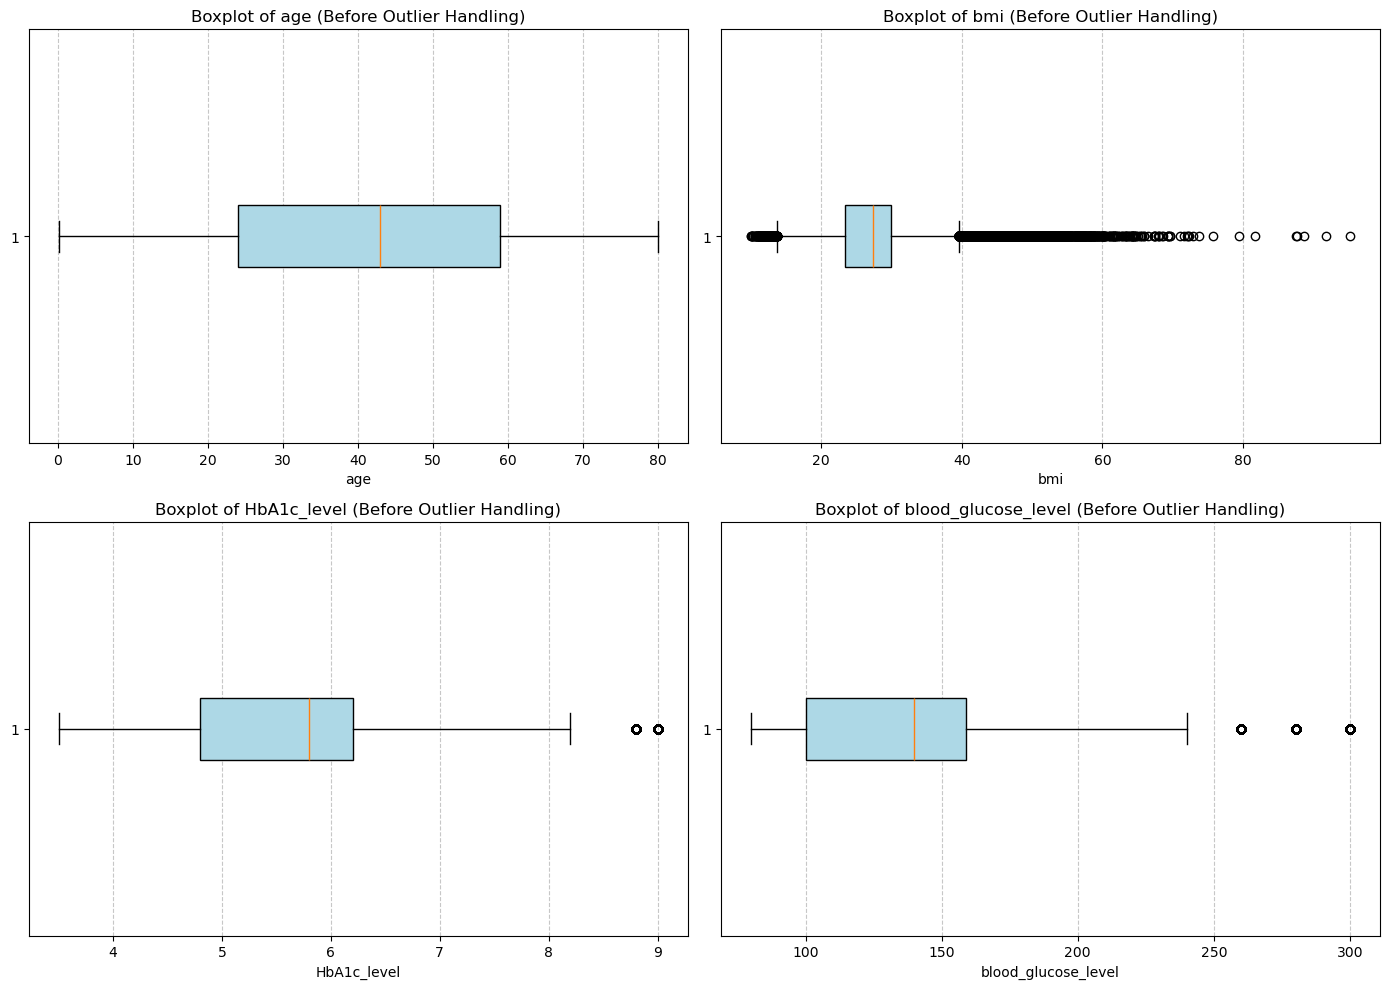

In [48]:
# Boxplot sebelum outlier ditangani
plt.figure(figsize=(14, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(X_train[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot of {column} (Before Outlier Handling)")
    plt.xlabel(column)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [49]:
# kolom yang berisi outlier yang akan ditangani
columns_to_modify = ['bmi', 'HbA1c_level', 'blood_glucose_level']

In [52]:
# fungsi untuk menangani outlier
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

In [54]:
for column in columns_to_modify:
    replace_outliers_with_median(X_train, column)

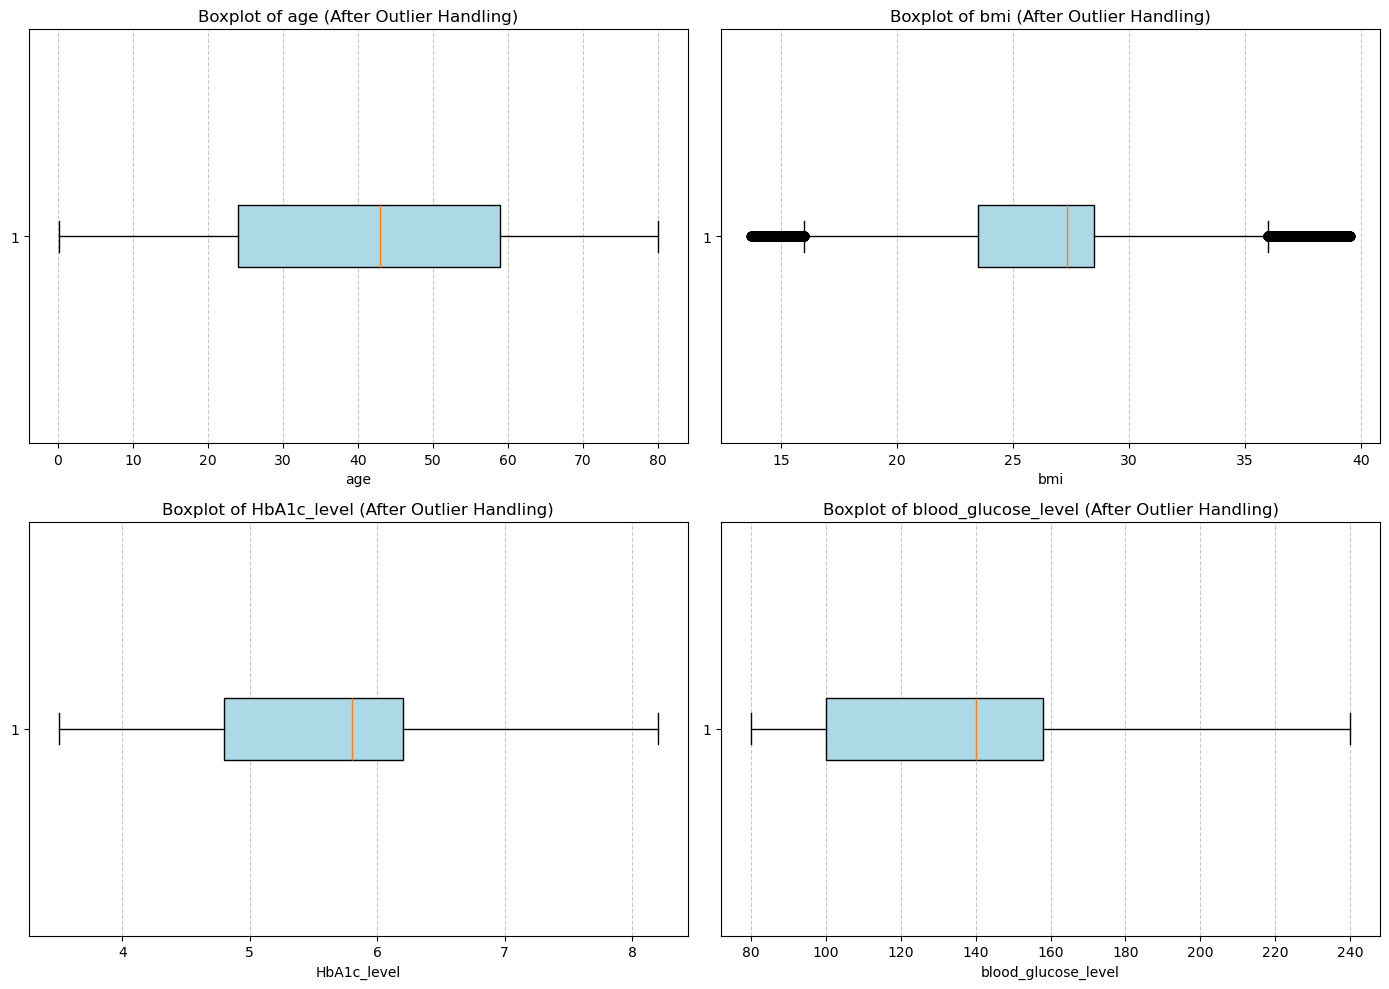

In [56]:
# Boxplot untuk lihat outlier setelah ditangani
plt.figure(figsize=(14, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(X_train[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(f"Boxplot of {column} (After Outlier Handling)")
    plt.xlabel(column)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [65]:
# Tangani ketidakseimbangan kelas menggunakan smote
print("Before SMOTE:")
print(y_train.value_counts())
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train.value_counts())

Before SMOTE:
diabetes
0    70130
1     6786
Name: count, dtype: int64
After SMOTE:
diabetes
0    70130
1    70130
Name: count, dtype: int64


In [69]:
X_train.columns = X_train.columns.str.replace(' ', '_')
X_val.columns = X_val.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [71]:
# Latih model
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 70130, number of negative: 70130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 140260, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [73]:
# Validasi model
val_preds = model.predict(X_val)
print("Validation Metrics:\n", classification_report(y_val, val_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

Validation Metrics:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8767
           1       0.78      0.76      0.77       848

    accuracy                           0.96      9615
   macro avg       0.88      0.87      0.87      9615
weighted avg       0.96      0.96      0.96      9615

Validation Accuracy: 0.9599583983359334
Validation Confusion Matrix:
 [[8584  183]
 [ 202  646]]


In [75]:
# Test model
test_preds = model.predict(X_test)
print("Test Metrics:\n", classification_report(y_test, test_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


Test Metrics:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      8767
           1       0.75      0.71      0.73       848

    accuracy                           0.95      9615
   macro avg       0.86      0.84      0.85      9615
weighted avg       0.95      0.95      0.95      9615

Test Accuracy: 0.9541341653666147
Test Confusion Matrix:
 [[8571  196]
 [ 245  603]]
